In [12]:
from collections import Counter
from scipy import stats, signal

import numpy as np
import pandas as pd
import pybedtools as bt

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Futura'
mpl.rcParams['savefig.transparent'] = True

# mpl.rcParams.keys()

# Investigation into the characteristics of metazoan ZNF clusters
ZNF clusters are pre-computed by merging any ZNF open-reading frames with 250kb of eachother (see methods and `../scripts/cluster-zfps/cluster_zfps.py`) for details. 

In [13]:
c = 0
inter_znf_distances = [] 
with open('../data/parsed_metazoans.out') as infile:
    for line in infile:
        if c > 1:
            break
        species = line.split('\t')[0]
        assembly_type = line.strip().split('\t')[-1]
        if assembly_type != 'Chromosome':
            continue
        try:
            znf_bed = bt.BedTool(f'/Users/jonwells/Projects/feschottelab/metazoan-znfs/data/beds/{species}_znfs.bed')
            dist_bed = znf_bed.closest(b=znf_bed, d=True, io=True)
            inter_znf_distances += [int(feature[-1]) for feature in dist_bed if feature[-1] != '-1']
        except:
            print(f'WARNING: error parsing {species}')

inter_znf_distances = np.array(inter_znf_distances)        

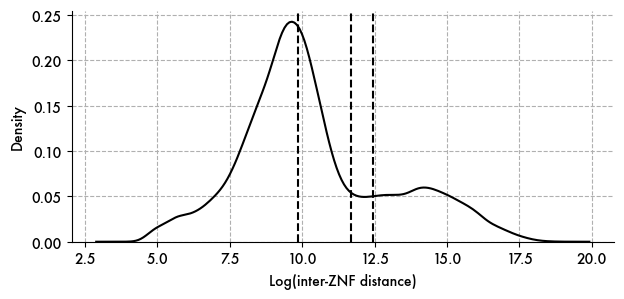

19077.0
118261.75


In [21]:
logdists = np.log(inter_znf_distances)

fig, ax = plt.subplots(figsize=(7, 3))
sns.kdeplot(logdists, bw_method=0.1, ax=ax, color='k')

for q in [0.5, 0.75]:
    qv = np.quantile(inter_znf_distances, q=q)
    ax.axvline(np.log(qv), color='k', ls='--')
ax.axvline(np.log(2.5e5), color='k', ls='--')

ax.set_xlabel('Log(inter-ZNF distance)')
sns.despine()

plt.savefig('../figures/inter_znf_distance.svg', bbox_inches='tight')
plt.show()

print(np.quantile(inter_znf_distances, q=0.5))
print(np.quantile(inter_znf_distances, q=0.75))

In [15]:
cluster_sizes = []
c = 0
with open('../data/parsed_metazoans.out') as infile:
    for line in infile:
        species = line.split('\t')[0]
        assembly_type = line.strip().split('\t')[-1]
        if assembly_type != 'Chromosome':
            continue
        try:
            with open(f'../data/beds/{species}_zf_clusters.bed') as clusterfile:
                for line in clusterfile:
                    cs = int(line.strip().split('\t')[4])
                    cluster_sizes.append(cs)
            c += 1
        except:
            print(f'WARNING: error parsing {species}')
cluster_sizes = np.array(cluster_sizes)
singletons = [c for c in cluster_sizes if c == 1] 
cluster_counts = np.array([[k for k, v in sorted(Counter(cluster_sizes).items())],
                  [v for k, v in sorted(Counter(cluster_sizes).items())]])

print()
print(f"{'Species:':15} {c}")
print(f"{'ZNFs:':<15} {cluster_sizes.sum()}")
print(f"{'ZNF clusters:':<15} {len(cluster_sizes)}")
print(f"{'Singletons:':<15} {len(singletons)}")
print(f"{'Max size:':<15} {cluster_sizes.max()}")
print(f"{'Mean:':<15} {cluster_sizes.mean()}")
print(f"{'Std. dev.:':<15} {cluster_sizes.std()}")


Species:        738
ZNFs:           317466
ZNF clusters:   129286
Singletons:     91228
Max size:       803
Mean:           2.4555326949553704
Std. dev.:      6.956799305971747


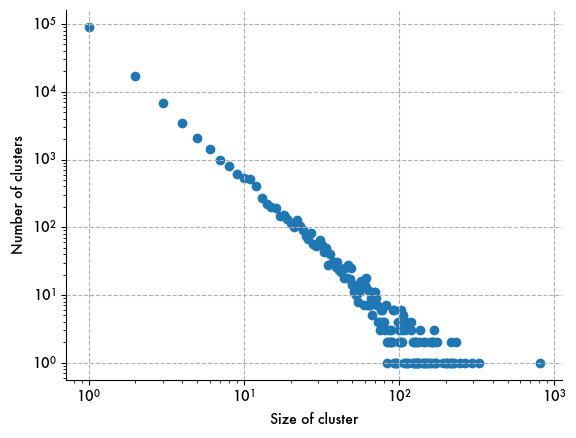

In [16]:
fig, ax = plt.subplots()
plt.scatter(cluster_counts[0], cluster_counts[1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Size of cluster')
ax.set_ylabel('Number of clusters')
sns.despine()
plt.show()

In [17]:
geom_fit = stats.fit(stats.geom, cluster_sizes, bounds={'p': (0, 1)})
yule_fit = stats.fit(stats.yulesimon, cluster_sizes, bounds={'alpha': (0, 10)})
zipf_fit = stats.fit(stats.zipf, cluster_sizes, bounds={'a': (1, 10)})

geom_sample = cluster_counts[1].sum()*stats.geom.pmf(cluster_counts[0], geom_fit.params.p)
yule_sample = cluster_counts[1].sum()*stats.yulesimon.pmf(cluster_counts[0], yule_fit.params.alpha)
zipf_sample = cluster_counts[1].sum()*stats.zipf.pmf(cluster_counts[0], zipf_fit.params.a)

geom_cvm = stats.cramervonmises_2samp(cluster_counts[1], geom_sample)
yule_cvm = stats.cramervonmises_2samp(cluster_counts[1], yule_sample)
zipf_cvm = stats.cramervonmises_2samp(cluster_counts[1], zipf_sample)

print(f"Geometric\n{geom_fit}\n{'CVM test: ':>10}D={geom_cvm.statistic:.4f}, pvalue={geom_cvm.pvalue:.3e}\n")
print(f"Yule-Simon\n{yule_fit}\n{'CVM test: ':>10}D={yule_cvm.statistic:.4f}, pvalue={yule_cvm.pvalue:.3e}\n")
print(f"Zipf\n{zipf_fit}\n{'CVM test: ':>10}D={zipf_cvm.statistic:.4f}, pvalue={zipf_cvm.pvalue:.3e}\n")


Geometric
  params: FitParams(p=0.40724359834167934, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
CVM test: D=18.2627, pvalue=2.880e-09

Yule-Simon
  params: FitParams(alpha=1.8550644101762979, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
CVM test: D=3.3847, pvalue=1.046e-08

Zipf
  params: FitParams(a=2.2825090080992316, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
CVM test: D=0.3500, pvalue=9.850e-02



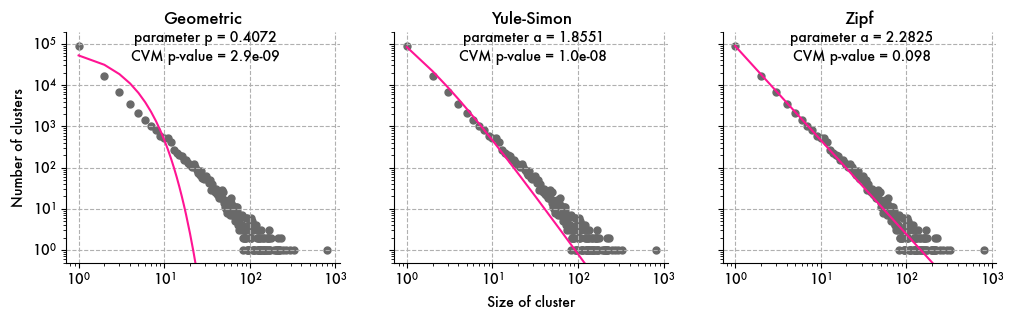

In [18]:
fig, ax = plt.subplots(figsize=(12, 3), ncols=3, sharex=True, sharey=True)

# Plot data
for i in range(3):
    ax[i].scatter(cluster_counts[0], cluster_counts[1], s=25, color='dimgrey')

ax[0].plot(cluster_counts[0], geom_sample, color='deeppink')
ax[1].plot(cluster_counts[0], yule_sample, color='deeppink')
ax[2].plot(cluster_counts[0], zipf_sample, color='deeppink')

# Annotate
ax[0].text(3e1, 4e4, f'parameter p = {geom_fit.params.p:.4f}\nCVM p-value = {geom_cvm.pvalue:.1e}', ha='center')
ax[1].text(3e1, 4e4, f'parameter a = {yule_fit.params.alpha:.4f}\nCVM p-value = {yule_cvm.pvalue:.1e}', ha='center')
ax[2].text(3e1, 4e4, f'parameter a = {zipf_fit.params.a:.4f}\nCVM p-value = {zipf_cvm.pvalue:.3f}', ha='center')

ax[0].set_title('Geometric')
ax[1].set_title('Yule-Simon')
ax[2].set_title('Zipf')

ax[1].set_xlabel('Size of cluster')
ax[0].set_ylabel('Number of clusters')
ax[0].set_ylim((5e-1, 2e5))
ax[0].set_xscale('log')
ax[0].set_yscale('log')

fig.savefig('../figures/cluster_distribution_cvmtest.svg', bbox_inches='tight')
sns.despine()
plt.show()

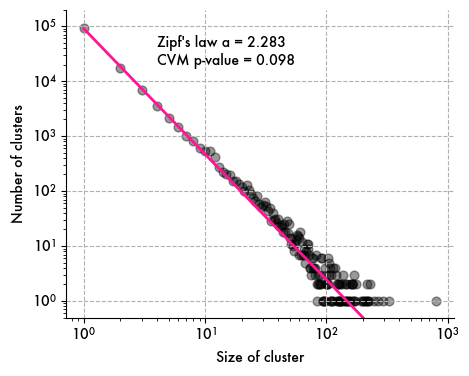

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(cluster_counts[0], cluster_counts[1], s=40, color='black', alpha=0.4)
ax.plot(cluster_counts[0], zipf_sample, color='deeppink', lw=2)    

ax.text(4e0, 2e4, f'Zipf\'s law a = {zipf_fit.params.a:.3f}\nCVM p-value = {zipf_cvm.pvalue:.3f}')

ax.set_xlabel('Size of cluster')
ax.set_ylabel('Number of clusters')
ax.set_ylim((5e-1, 2e5))
ax.set_xscale('log')
ax.set_yscale('log')

sns.despine()
fig.savefig('../figures/cluster_zipf.svg', bbox_inches='tight')
plt.show()

I had some concerns that using the absolute size of the cluster when fitting Zipf's distribution was not really appropriate, since the probability mass function explicitly takes ranks as input. However, I think this fear is unfounded, since cluster sizes naturally rank themselves. In this case, the largest cluster is 803, but we can imagine that if we could increase the size of our dataset, then the missing cluster sizes in between would naturally fill in until the rank of the cluster of size 803 was exactly 803. In the following code block, I demonstrate that Zipf's law is an excellent fit for the first 82 clusters where rank == cluster size.

n clusters where cluster size == rank: 94
Zipf
  params: FitParams(a=2.2907642418360137, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
CVM test: D=0.3500, pvalue=6.648e-01



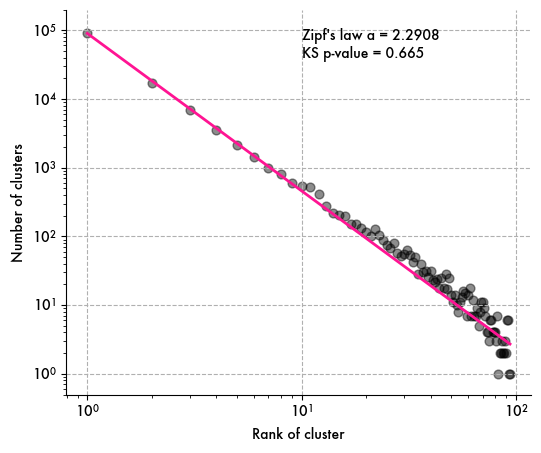

In [9]:
rank_dict = {val: i for i, val in enumerate(sorted(cluster_counts[0]), 1)}
zipf_data = [rank_dict[s] for s in cluster_sizes if s == rank_dict[s]]
zipf_ranks = [rank_dict[s] for s in cluster_counts[0] if s == rank_dict[s]]
n = len(zipf_ranks)
print(f'n clusters where cluster size == rank: {n}')

zipf_fit = stats.fit(stats.zipf, zipf_data, bounds={'a': (1, 10)})
zipf_sample = cluster_counts[1][:n].sum()*stats.zipf.pmf(zipf_ranks, zipf_fit.params.a)
zipf_ks = stats.ks_2samp(cluster_counts[1][:n], zipf_sample)
print(f"Zipf\n{zipf_fit}\n{'CVM test: ':>10}D={zipf_cvm.statistic:.4f}, pvalue={zipf_ks.pvalue:.3e}\n")

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(zipf_ranks, cluster_counts[1][:n], s=40, color='black', alpha=0.45)
ax.plot(zipf_ranks, zipf_sample, color='deeppink', lw=2)    

ax.text(1e1, 4e4, f'Zipf\'s law a = {zipf_fit.params.a:.4f}\nKS p-value = {zipf_ks.pvalue:.3f}')

ax.set_xlabel('Rank of cluster')
ax.set_ylabel('Number of clusters')
ax.set_ylim((5e-1, 2e5))
ax.set_xscale('log')
ax.set_yscale('log')

sns.despine()
plt.show()

In [ ]:
repeatmasker_dir = '../data/repeatmasker-out'
repeatmasker_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_rm.bed',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_rm.bed',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_rm.bed',
    'Petromyzon_marinus': 'Petromyzon_marinus.bed',
    'Strongylocentrotus_purpuratus': 'Strongylocentrotus_purpuratus.bed',
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_genomic.fna.bed',
}

genome_dir = '../data/genomes'
genome_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_genomic.genome',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_genomic.genome',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_genomic.nonalt.genome',
    'Branchiostoma_floridae': 'Branchiostoma_floridae.genome',
    'Petromyzon_marinus': 'Petromyzon_marinus.genome',
    'Strongylocentrotus_purpuratus': 'Strongylocentrotus_purpuratus.genome',    
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_genomic.genome',
}

gff_dir = '../data/gffs'
gff_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_CDS.gff',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_CDS.gff',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_CDS.gff',
    'Branchiostoma_floridae': 'Branchiostoma_floridae_CDS.gff',
    'Petromyzon_marinus': 'Petromyzon_marinus_CDS.gff',
    'Strongylocentrotus_purpuratus': 'Strongylocentrotus_purpuratus_CDS.gff',
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_CDS.gff',
}
te_bed_names=['chrom', 'start', 'end', 
              'tename', 'swscore', 'strand', 
              'pdiv', 'pdel', 'pins', 
              'sleft', 'tetype', 'qstart', 'qend', 'qleft', 'repeat_id']
zf_bed_names=['zchrom', 'zstart', 'zend']

In [ ]:
def load_beds(species):
    te_bed = bt.BedTool(f'{repeatmasker_dir}/{species}/{repeatmasker_files[species]}')
    znf_bed = bt.BedTool(f'../data/beds/{species}_zf_clusters.bed')
    other_genes_bed = bt.BedTool(f'{gff_dir}/{gff_files[species]}')
    return te_bed, znf_bed, other_genes_bed

def process_beds(species, te_bed, znf_bed, other_genes_bed):
    genomefile = f'{genome_dir}/{genome_files[species]}'

    # Extract windows around other genes
    control_genes_bed = other_genes_bed \
        .sort() \
        .slop(g=genomefile,
              b=5e4) \
        .merge()
    control_genes_bed = control_genes_bed.makewindows(w=1e4, b=control_genes_bed) \
        .subtract(b=observations_bed) \
        .subtract(b=other_genes_bed)

    # Shuffle windows from gene fam of interest
    shuffled_observations_bed = observations_bed \
        .shuffle(g=genomefile)
    
    return observations_bed, shuffled_observations_bed, control_genes_bed
    
def label_dfs(obs_df, shuf_df, other_genes_df, species):
    obs_df['species'] = species
    shuf_df['species'] = species
    other_genes_df['species'] = species
    obs_df['group'] = 'observed'
    shuf_df['group'] = 'shuffled'
    other_genes_df['group'] = 'other'
    return obs_df, shuf_df, other_genes_df

In [ ]:
te_bed, znf_bed, other_genes_bed = load_beds('Rana_temporaria')

In [ ]:
coverage_df = []
for species, accession in repeatmasker_files.items():
    print(species)
    te_bed, zf_bed, other_genes_bed = load_beds(species)
    zf_bed, shuffled_zf_bed, control_genes_bed = process_beds(species, te_bed, zf_bed, other_genes_bed)
    # print(control_genes_bed.head())
    
    obs_df = zf_bed.coverage(b=te_bed).to_dataframe()
    shuf_df = shuffled_zf_bed.coverage(b=te_bed).to_dataframe()
    genes_df = control_genes_bed.coverage(b=te_bed).to_dataframe()
    obs_df, shuf_df, genes_df = label_dfs(obs_df, shuf_df, genes_df, species)

    coverage_df.append(obs_df)
    coverage_df.append(shuf_df)
    coverage_df.append(genes_df)

coverage_df = pd.concat(coverage_df).rename({'thickStart': 'coverage'}, axis=1)
coverage_df['length'] = abs(coverage_df.end - coverage_df.start)
coverage_df = coverage_df.loc[coverage_df.length >= 500]

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data=coverage_df.loc[coverage_df.length >= 1000], x='species', y='coverage', hue='group', notch=True, palette='twilight_shifted')
# ax.set_yscale('log')
sns.despine()
plt.xticks(rotation=40, ha='right')
plt.show()